# ==== Import Library ====

In [1]:
# import library
import argparse,copy,h5py, os,sys,time,socket
import numpy as np
import tensorflow as tf
import torch,torchvision,torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from   torchsummary import summary
from   torch.autograd.variable import Variable

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import ticker,colors

# seed value and plotly
init_notebook_mode(connected=True); torch.manual_seed(7); torch.cuda.manual_seed_all(7); np.set_printoptions(suppress=True,precision=3,); tf.set_random_seed(7)

# ==== Set up the Network ====

In [4]:
# need the module 
class AllConvNet(nn.Module):
    
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 96, 3, padding=1,bias=False)
        self.conv2 = nn.Conv2d(96, 96, 3, padding=1,bias=False)
        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2,bias=False)
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1,bias=False)
        self.conv5 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2,bias=False)
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.conv8 = nn.Conv2d(192, 192, 1,bias=False)
        self.class_conv = nn.Conv2d(192, n_classes, 1,bias=False)

    def forward(self, x):
        
        conv1_out = F.relu(self.conv1(x))
        conv2_out = F.relu(self.conv2(conv1_out))
        conv3_out = F.relu(self.conv3(conv2_out))
        
        conv4_out = F.relu(self.conv4(conv3_out))
        conv5_out = F.relu(self.conv5(conv4_out))
        conv6_out = F.relu(self.conv6(conv5_out))
        
        conv7_out = F.relu(self.conv7(conv6_out))
        conv8_out = F.relu(self.conv8(conv7_out))
        class_out = F.relu(self.class_conv(conv8_out))
        pool_out  = F.adaptive_avg_pool2d(class_out, 1)
        
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out
class AllConvNet_BN(nn.Module):
    
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet_BN, self).__init__()
        
        self.conv1 = nn.Conv2d(input_size,96, 3, padding=1,bias=False)
        self.bn1   = nn.BatchNorm2d(96)

        self.conv2 = nn.Conv2d(96, 96, 3, padding=1,bias=False)
        self.bn2   = nn.BatchNorm2d(96)

        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2,bias=False)
        self.bn3   = nn.BatchNorm2d(96)
        
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1,bias=False)
        self.bn4   = nn.BatchNorm2d(192)

        self.conv5 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.bn5   = nn.BatchNorm2d(192)

        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2,bias=False)
        self.bn6   = nn.BatchNorm2d(192)
        
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.bn7   = nn.BatchNorm2d(192)
        
        self.conv8 = nn.Conv2d(192, 192, 1,bias=False)
        self.bn8   = nn.BatchNorm2d(192)
        
        self.class_conv = nn.Conv2d(192, n_classes, 1,bias=False)
    def forward(self, x):
        
        conv1_out = F.relu(self.conv1(x))
        conv1_out = self.bn1(conv1_out)
        
        conv2_out = F.relu(self.conv2(conv1_out))
        conv2_out = self.bn2(conv2_out)

        conv3_out = F.relu(self.conv3(conv2_out))
        conv3_out = self.bn3(conv3_out)
        
        conv4_out = F.relu(self.conv4(conv3_out))
        conv4_out = self.bn4(conv4_out)

        conv5_out = F.relu(self.conv5(conv4_out))
        conv5_out = self.bn5(conv5_out)

        conv6_out = F.relu(self.conv6(conv5_out))
        conv6_out = self.bn6(conv6_out)
        
        conv7_out = F.relu(self.conv7(conv6_out))
        conv7_out = self.bn7(conv7_out)

        conv8_out = F.relu(self.conv8(conv7_out))
        conv8_out = self.bn8(conv8_out)

        class_out = F.relu(self.class_conv(conv8_out))
        pool_out  = F.adaptive_avg_pool2d(class_out, 1)
        
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out
class AllConvNet_LocalRN(nn.Module):
    
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet_LocalRN, self).__init__()
        
        self.conv1 = nn.Conv2d(input_size,96, 3, padding=1,bias=False)
        self.bn1   = nn.LocalResponseNorm(96)

        self.conv2 = nn.Conv2d(96, 96, 3, padding=1,bias=False)
        self.bn2   = nn.LocalResponseNorm(96)

        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2,bias=False)
        self.bn3   = nn.LocalResponseNorm(96)
        
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1,bias=False)
        self.bn4   = nn.LocalResponseNorm(192)

        self.conv5 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.bn5   = nn.LocalResponseNorm(192)

        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2,bias=False)
        self.bn6   = nn.LocalResponseNorm(192)
        
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.bn7   = nn.LocalResponseNorm(192)
        
        self.conv8 = nn.Conv2d(192, 192, 1,bias=False)
        self.bn8   = nn.LocalResponseNorm(192)
        
        self.class_conv = nn.Conv2d(192, n_classes, 1,bias=False)
    def forward(self, x):
        
        conv1_out = F.relu(self.conv1(x))
        conv1_out = self.bn1(conv1_out)
        
        conv2_out = F.relu(self.conv2(conv1_out))
        conv2_out = self.bn2(conv2_out)

        conv3_out = F.relu(self.conv3(conv2_out))
        conv3_out = self.bn3(conv3_out)
        
        conv4_out = F.relu(self.conv4(conv3_out))
        conv4_out = self.bn4(conv4_out)

        conv5_out = F.relu(self.conv5(conv4_out))
        conv5_out = self.bn5(conv5_out)

        conv6_out = F.relu(self.conv6(conv5_out))
        conv6_out = self.bn6(conv6_out)
        
        conv7_out = F.relu(self.conv7(conv6_out))
        conv7_out = self.bn7(conv7_out)

        conv8_out = F.relu(self.conv8(conv7_out))
        conv8_out = self.bn8(conv8_out)

        class_out = F.relu(self.class_conv(conv8_out))
        pool_out  = F.adaptive_avg_pool2d(class_out, 1)
        
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out

In [5]:
# load model with some batch size
batch_size = 128 ; learning_rate = 0.0008
net        = AllConvNet_LocalRN(3).cuda()

# load the loss 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

net.eval()
summary(net, (3, 32, 32))
print("Cuda: ",next(net.parameters()).is_cuda)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,592
 LocalResponseNorm-2           [-1, 96, 32, 32]               0
            Conv2d-3           [-1, 96, 32, 32]          82,944
 LocalResponseNorm-4           [-1, 96, 32, 32]               0
            Conv2d-5           [-1, 96, 16, 16]          82,944
 LocalResponseNorm-6           [-1, 96, 16, 16]               0
            Conv2d-7          [-1, 192, 16, 16]         165,888
 LocalResponseNorm-8          [-1, 192, 16, 16]               0
            Conv2d-9          [-1, 192, 16, 16]         331,776
LocalResponseNorm-10          [-1, 192, 16, 16]               0
           Conv2d-11            [-1, 192, 8, 8]         331,776
LocalResponseNorm-12            [-1, 192, 8, 8]               0
           Conv2d-13            [-1, 192, 8, 8]         331,776
LocalResponseNorm-14            [-1, 19

In [6]:
#  Get the weights - after training
def get_weights(net):            return [p.data for p in net.parameters()]
def get_random_weights(weights): return [torch.randn(w.size()) for w in weights]
def normalize_direction(direction, weights,norm='layer'):
    if norm == 'filter':
        # Rescale the filters (weights in group) in 'direction' so that each filter has the same norm as its corresponding filter in 'weights'.
        for d, w in zip(direction, weights): 
            # the direction channel gets norm via the channel
            d.mul_(w.norm()/(d.norm() + 1e-10))

    elif norm == 'layer':
        # Rescale the layer variables in the direction so that each layer has the same norm as the layer variables in weights.
        direction.mul_(weights.norm()/direction.norm())

    elif norm == 'weight':
        # Rescale the entries in the direction so that each entry has the same scale as the corresponding weight.
        direction.mul_(weights.cpu())

    elif norm == 'dfilter':
        # Rescale the entries in the direction so that each filter direction has the unit norm.
        for d in direction: 
            d.div_(d.norm() + 1e-10)

    elif norm == 'dlayer':
        # Rescale the entries in the direction so that each layer direction has the unit norm.
        direction.div_(direction.norm())
weight      = get_weights(net)
temp_layer  = 0
for x in weight: 
    temp_layer = temp_layer + 1
    print(str(temp_layer) + " layer " + str(x.shape))

1 layer torch.Size([96, 3, 3, 3])
2 layer torch.Size([96, 96, 3, 3])
3 layer torch.Size([96, 96, 3, 3])
4 layer torch.Size([192, 96, 3, 3])
5 layer torch.Size([192, 192, 3, 3])
6 layer torch.Size([192, 192, 3, 3])
7 layer torch.Size([192, 192, 3, 3])
8 layer torch.Size([192, 192, 1, 1])
9 layer torch.Size([10, 192, 1, 1])


In [7]:
# prepare the data set - here CIFAR
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],std=[x/255.0 for x in [63.0, 62.1, 66.7]])
transform = transforms.Compose([transforms.ToTensor(),normalize,])
trainset    = torchvision.datasets.CIFAR10(root='.', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=3)
testset     = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform)
testloader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
classes     = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(trainset)
print(testset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: .
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.4913725490196078, 0.4823529411764706, 0.4466666666666667], std=[0.24705882352941178, 0.24352941176470588, 0.2615686274509804])
                         )
    Target Transforms (if any): None
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: .
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.4913725490196078, 0.4823529411764706, 0.4466666666666667], std=[0.24705882352941178, 0.24352941176470588, 0.2615686274509804])
                         )
    Target Transforms (if any): None


# ==== Train the Network & Get Converged Weights ====

In [8]:
# train the network
num_epoch   = 100
acurracy_list_train = []; loss_list_train     = []; acurracy_list_test  = []; loss_list_test     = []

for epoch in range(num_epoch):  # loop over the dataset multiple times
    correct_train    = 0; total_loss_train = 0; total_train      = 0 
    for batch_idx, (inputs, targets) in enumerate(trainloader):
    
        # modify the inputs
        batch_size  = inputs.size(0)
        total_train = total_train + batch_size
        inputs  = Variable(inputs);      targets = Variable(targets)
        inputs, targets = inputs.cuda(), targets.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # get the output and calculate loss and acc
        outputs = net(inputs)
        loss    = criterion(outputs, targets)
        total_loss_train   = total_loss_train + loss.item()*batch_size
        _, predicted = torch.max(outputs.data, 1)
        correct_train      = correct_train + predicted.eq(targets).sum().item()
        
        # update
        loss.backward(); optimizer.step()
        
        # print
        sys.stdout.write("Epoch: "+str(epoch)+" i : "+str(batch_idx+1)+" and loss: "+str(np.around(loss.item(),3))+" acc: "+str(predicted.eq(targets).sum().item()/batch_size)+"\r")
        sys.stdout.flush()
    sys.stdout.write("\tEpoch: "+str(epoch)+"\tTrain loss: "+str(np.around(total_loss_train/total_train,3))+"\tTrain Acc: "+str(100.*correct_train/total_train)+"\n")
    loss_list_train.append(total_loss_train/total_train) ;acurracy_list_train.append(100.*correct_train/total_train)
    
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            batch_size = inputs.size(0)
            total += batch_size
            inputs  = Variable(inputs); targets = Variable(targets)
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            # print
            sys.stdout.write("Epoch: "+str(epoch)+" i : "+str(batch_idx+1)+" and loss: "+str(np.around(loss.item(),3))+" acc: "+str(predicted.eq(targets).sum().item()/batch_size)+"\r")
            sys.stdout.flush()
    sys.stdout.write("\tEpoch: "+str(epoch)+"\tTest loss: "+str(np.around(total_loss/total,3))+"\tTest Acc: "+str(100.*correct/total)+"\n")
    loss_list_test.append(total_loss/total) ;acurracy_list_test.append(100.*correct/total)
    sys.stdout.write("==========================\n")

	Epoch: 0	Train loss: 1.977	Train Acc: 24.50875
	Epoch: 0	Test loss: 1.652	Test Acc: 37.715255
	Epoch: 1	Train loss: 1.467	Train Acc: 45.48425
	Epoch: 1	Test loss: 1.286	Test Acc: 53.121255
	Epoch: 2	Train loss: 1.165	Train Acc: 58.03625
	Epoch: 2	Test loss: 1.068	Test Acc: 62.617555
	Epoch: 3	Train loss: 0.975	Train Acc: 65.63675
	Epoch: 3	Test loss: 0.996	Test Acc: 65.413755
	Epoch: 4	Train loss: 0.851	Train Acc: 70.16875
	Epoch: 4	Test loss: 0.939	Test Acc: 67.878125
	Epoch: 5	Train loss: 0.748	Train Acc: 73.95675
	Epoch: 5	Test loss: 0.819	Test Acc: 72.695255
	Epoch: 6	Train loss: 0.661	Train Acc: 77.03855
	Epoch: 6	Test loss: 0.743	Test Acc: 75.365625
	Epoch: 7	Train loss: 0.592	Train Acc: 79.48855
	Epoch: 7	Test loss: 0.762	Test Acc: 75.065875
	Epoch: 8	Train loss: 0.546	Train Acc: 81.12125
	Epoch: 8	Test loss: 0.759	Test Acc: 75.597525
	Epoch: 9	Train loss: 0.481	Train Acc: 83.35625
	Epoch: 9	Test loss: 0.721	Test Acc: 76.543755
	Epoch: 10	Train loss: 0.43	Train Acc: 85.198875
	

	Epoch: 66	Train loss: 0.033	Train Acc: 98.94825
	Epoch: 66	Test loss: 1.794	Test Acc: 78.725875
	Epoch: 67	Train loss: 0.036	Train Acc: 98.88755
	Epoch: 67	Test loss: 1.753	Test Acc: 77.835875
	Epoch: 68	Train loss: 0.029	Train Acc: 99.06655
	Epoch: 68	Test loss: 1.756	Test Acc: 78.910625
	Epoch: 69	Train loss: 0.03	Train Acc: 99.034875
	Epoch: 69	Test loss: 1.759	Test Acc: 78.945255
	Epoch: 70	Train loss: 0.026	Train Acc: 99.17655
	Epoch: 70	Test loss: 1.846	Test Acc: 78.325255
	Epoch: 71	Train loss: 0.03	Train Acc: 99.068875
	Epoch: 71	Test loss: 1.878	Test Acc: 78.985755
	Epoch: 72	Train loss: 0.03	Train Acc: 98.986875
	Epoch: 72	Test loss: 1.774	Test Acc: 79.181255
	Epoch: 73	Train loss: 0.033	Train Acc: 98.98875
	Epoch: 73	Test loss: 1.653	Test Acc: 79.346255
	Epoch: 74	Train loss: 0.025	Train Acc: 99.22655
	Epoch: 74	Test loss: 1.82	Test Acc: 79.2421875
	Epoch: 75	Train loss: 0.022	Train Acc: 99.31875
	Epoch: 75	Test loss: 1.823	Test Acc: 77.995755
	Epoch: 76	Train loss: 0.033	T

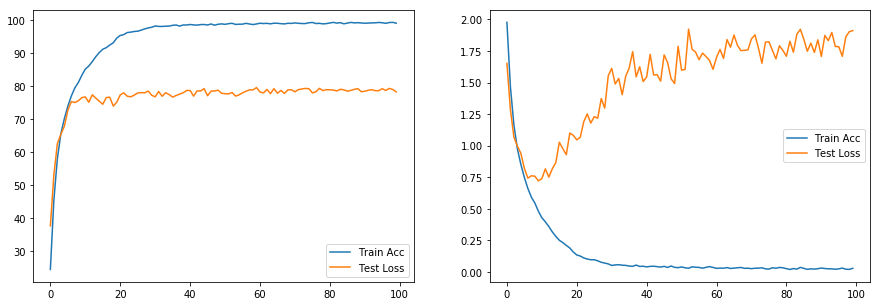

In [9]:
# get the converged weights and plot them save the accuracy
converged_weights = get_weights(net)
plt.figure(figsize=(15,5))
plt.subplot(121); 
plt.plot(acurracy_list_train,label='Train Acc')
plt.plot(acurracy_list_test,label='Test Loss')
plt.legend()

plt.subplot(122); 
plt.plot(loss_list_train,label='Train Acc')
plt.plot(loss_list_test,label='Test Loss')

plt.legend()
plt.show()

np.save('c_acurracy_list_train.npy', np.asarray(acurracy_list_train))
np.save('c_acurracy_list_test.npy', np.asarray(acurracy_list_test))
np.save('c_loss_list_train.npy', np.asarray(loss_list_train))
np.save('c_loss_list_test.npy', np.asarray(loss_list_test))

In [10]:
# create help functions
def viz_histogram_weights(converged_weights, direction1,direction2,title="None"):
    plt.figure(figsize=(55,55//9))
    plt.suptitle(title, fontsize=20, y=1.15)
    for layer_index in range(len(converged_weights)):
        plt.subplot(1,9,layer_index+1)
        plt.title("Layer : " + str(layer_index))
        plt.hist(converged_weights[layer_index].cpu().numpy().ravel(),50,alpha=0.6,label='Weight')
        plt.hist(direction1[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 1')
        plt.hist(direction2[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 2')
        plt.yticks([])
        plt.legend()
    plt.show()
def create_viz(loss_list,acc_list,title="none"):
    
    # plot the loss functions
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.title("Original Contour")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    plt.clabel(CS, inline=1, fontsize=8)

    plt.subplot(132)
    plt.title("Original Contour with Color")
    plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    CS = plt.contourf(xcoord_mesh, ycoord_mesh, loss_list, 10, zorder=1, cmap='terrain', linestyles='--')   
    plt.clabel(CS, fontsize=12,inline=0,fmt = '%2.1f')
    plt.colorbar(CS)

    plt.subplot(133)
    plt.title("Log Scale")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, np.log(loss_list+1e-8),10,zorder=1, cmap='terrain', linestyles='--'); 
    plt.clabel(CS, fontsize=8,inline=1)

    plt.savefig(title)
    plt.show()
    
    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(loss_list.max()-loss_list.min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+loss_list.min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=loss_list,colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(np.log(loss_list).max()-np.log(loss_list).min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+np.log(loss_list).min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(loss_list),colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Log Scale Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

In [11]:
# create the coordinates
numebr_of_points = 21 ; small_range = -1.0 ; large_range =  1.0

xcoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
ycoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 

xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
inds = np.array(range(numebr_of_points**2))
s1   = xcoord_mesh.ravel()[inds]
s2   = ycoord_mesh.ravel()[inds]
coordinate = np.c_[s1,s2]
print('From ',small_range,' to ',large_range,' with ',numebr_of_points,' total number of coordinate: ', numebr_of_points**2)

From  -1.0  to  1.0  with  21  total number of coordinate:  441


In [12]:
torch.save(net, 'relu_LocalRN.pth.tar')

C:\ProgramData\Miniconda3\lib\site-packages\torch\serialization.py:250: UserWarning:

Couldn't retrieve source code for container of type AllConvNet_LocalRN. It won't be checked for correctness upon loading.



# ==== Play Around with the Weigths ====

In [13]:
copy_of_the_weights = [ w.clone() for w in converged_weights]
sess = tf.InteractiveSession()

In [14]:
# create help functions
def viz_histogram_weights(converged_weights, direction1,direction2,title="None"):
    plt.figure(figsize=(55,55//9))
    plt.suptitle(title, fontsize=20, y=1.15)
    current_image = 1
    for layer_index in range(len(converged_weights)):
        if  converged_weights[layer_index].dim() > 1:
            plt.subplot(1,9,current_image)
            plt.title("Layer : " + str(layer_index))
            plt.hist(converged_weights[layer_index].cpu().numpy().ravel(),50,alpha=0.6,label='Weight')
            plt.hist(direction1[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 1')
            plt.hist(direction2[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 2')
            plt.yticks([])
            plt.legend()
            current_image = current_image + 1 
    plt.show()
def create_viz(loss_list,acc_list,title="none"):
    
    # plot the loss functions
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.title("Original Contour")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    plt.clabel(CS, inline=1, fontsize=8)

    plt.subplot(132)
    plt.title("Original Contour with Color")
    plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    CS = plt.contourf(xcoord_mesh, ycoord_mesh, loss_list, 10, zorder=1, cmap='terrain', linestyles='--')   
    plt.clabel(CS, fontsize=12,inline=0,fmt = '%2.1f')
    plt.colorbar(CS)

    plt.subplot(133)
    plt.title("Log Scale")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, np.log(loss_list+1e-8),10,zorder=1, cmap='terrain', linestyles='--'); 
    plt.clabel(CS, fontsize=8,inline=1)

    plt.savefig(title)
    plt.show()
    
    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(loss_list.max()-loss_list.min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+loss_list.min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=loss_list,colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(np.log(loss_list).max()-np.log(loss_list).min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+np.log(loss_list).min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(loss_list),colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Log Scale Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

# ==== 1. Random - Filter Normalization - whole norm ====

In [15]:
random_direction1 = get_random_weights(copy_of_the_weights)
random_direction2 = get_random_weights(copy_of_the_weights)

for d1,d2,w in zip(random_direction1,random_direction2,copy_of_the_weights):
    
    if w.dim() == 1:
        d1.data = torch.zeros_like(w)
        d2.data = torch.zeros_like(w)
    else:
        w_norm  = w.view((w.shape[0],-1))  .norm(dim=(1),keepdim=True)[:,:,None,None]
        d_norm1 = d1.view((d1.shape[0],-1)).norm(dim=(1),keepdim=True)[:,:,None,None]
        d_norm2 = d2.view((d2.shape[0],-1)).norm(dim=(1),keepdim=True)[:,:,None,None]

        d1.data = d1.cuda() * (w_norm/(d_norm1.cuda()+1e-10))
        d2.data = d2.cuda() * (w_norm/(d_norm2.cuda()+1e-10))

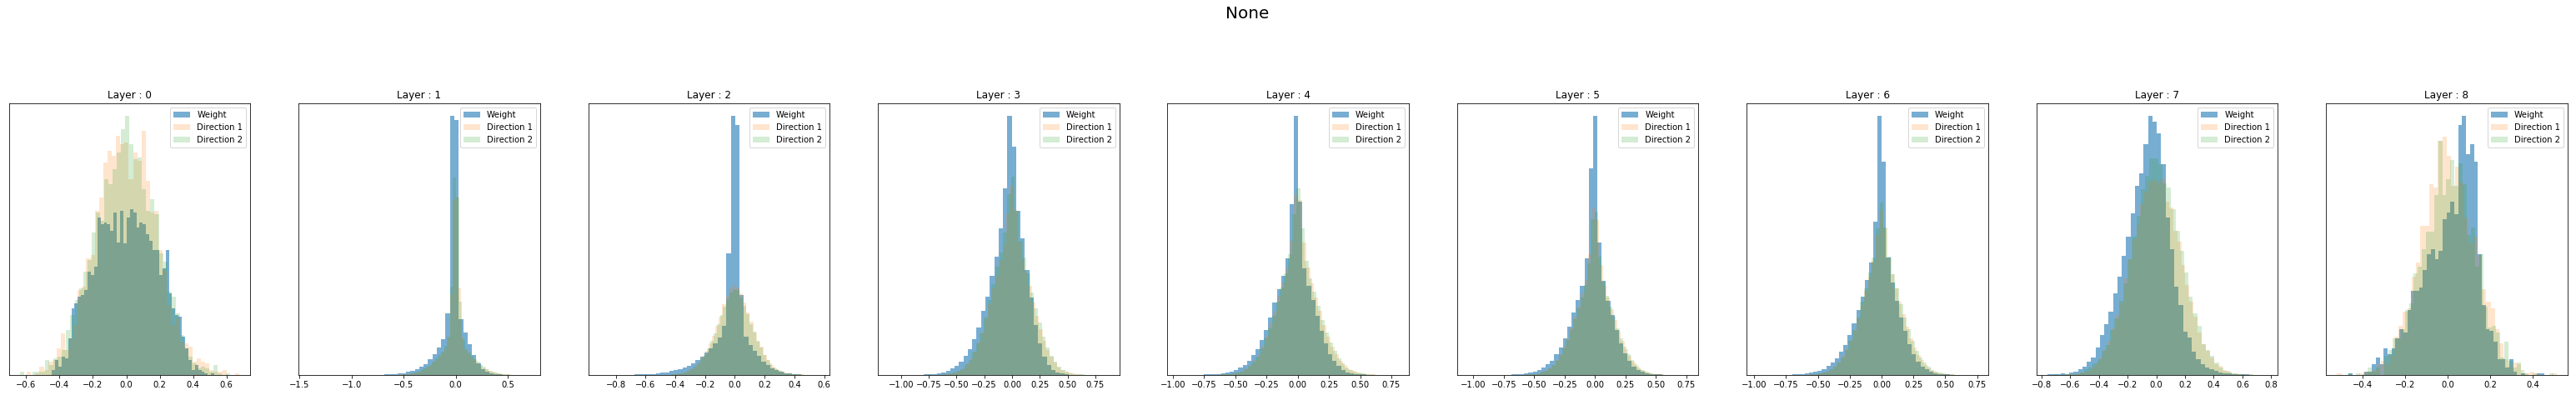

In [16]:
viz_histogram_weights(copy_of_the_weights,random_direction1,random_direction2)

In [17]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(random_direction1, random_direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 13.28125	Loss: 50.702
count: 2	Coord: [-0.8 -1. ]		Acc: 13.352272727272727	Loss: 45.209
count: 4	Coord: [-0.6 -1. ]		Acc: 13.494318181818182	Loss: 42.166
count: 6	Coord: [-0.4 -1. ]		Acc: 16.193181818181817	Loss: 37.866
count: 8	Coord: [-0.2 -1. ]		Acc: 18.039772727272727	Loss: 32.554
count: 10	Coord: [ 0. -1.]		Acc: 16.974431818181817	Loss: 29.464
count: 12	Coord: [ 0.2 -1. ]		Acc: 15.625	Loss: 29.47
count: 14	Coord: [ 0.4 -1. ]		Acc: 14.985795454545455	Loss: 32.642
count: 16	Coord: [ 0.6 -1. ]		Acc: 14.488636363636363	Loss: 38.449
count: 18	Coord: [ 0.8 -1. ]		Acc: 13.423295454545455	Loss: 46.664
count: 20	Coord: [ 1. -1.]		Acc: 11.150568181818182	Loss: 55.433
count: 22	Coord: [-0.9 -0.9]		Acc: 13.778409090909092	Loss: 40.672
count: 24	Coord: [-0.7 -0.9]		Acc: 15.482954545454545	Loss: 35.876
count: 26	Coord: [-0.5 -0.9]		Acc: 18.75	Loss: 31.41
count: 28	Coord: [-0.3 -0.9]		Acc: 21.59090909090909	Loss: 26.888
count: 30	Coord: [-0.1 -0.9]		Acc: 23.082386

count: 252	Coord: [-1.   0.2]		Acc: 19.957386363636363	Loss: 29.825
count: 254	Coord: [-0.8  0.2]		Acc: 33.23863636363637	Loss: 14.75
count: 256	Coord: [-0.6  0.2]		Acc: 49.21875	Loss: 7.321
count: 258	Coord: [-0.4  0.2]		Acc: 69.46022727272727	Loss: 2.85
count: 260	Coord: [-0.2  0.2]		Acc: 87.92613636363636	Loss: 0.631
count: 262	Coord: [0.  0.2]		Acc: 96.09375	Loss: 0.159
count: 264	Coord: [0.2 0.2]		Acc: 92.75568181818181	Loss: 0.331
count: 266	Coord: [0.4 0.2]		Acc: 79.61647727272727	Loss: 1.465
count: 268	Coord: [0.6 0.2]		Acc: 57.03125	Loss: 5.091
count: 270	Coord: [0.8 0.2]		Acc: 39.63068181818182	Loss: 11.865
count: 272	Coord: [1.  0.2]		Acc: 27.05965909090909	Loss: 21.246
count: 274	Coord: [-0.9  0.3]		Acc: 21.661931818181817	Loss: 24.399
count: 276	Coord: [-0.7  0.3]		Acc: 36.43465909090909	Loss: 12.682
count: 278	Coord: [-0.5  0.3]		Acc: 53.26704545454545	Loss: 6.34
count: 280	Coord: [-0.3  0.3]		Acc: 72.3721590909091	Loss: 2.417
count: 282	Coord: [-0.1  0.3]		Acc: 86.576704

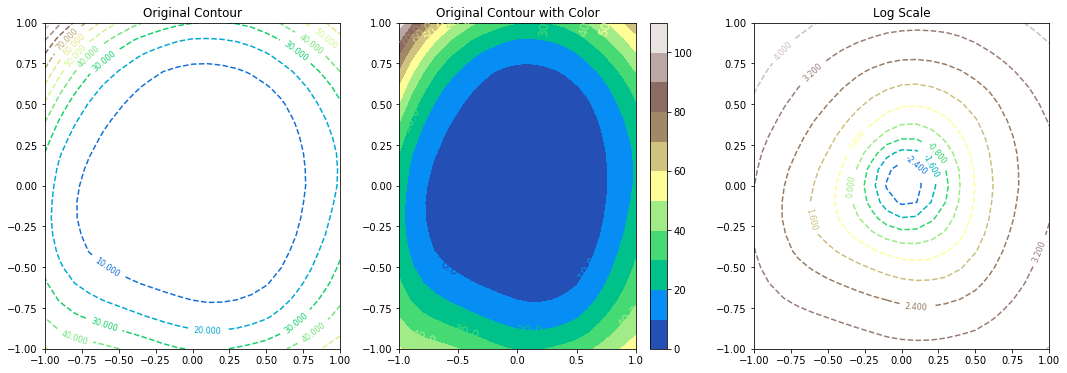

In [18]:
create_viz(loss_list,acc_list)

# ==== 2. Random - Orthogonal - whole norm ====

In [25]:
# np.save('c_loss_list_1.npy', np.asarray(loss_list))
# np.save('c_acc_list_1.npy', np.asarray(acc_list))
random_direction1 = get_random_weights(copy_of_the_weights)
random_direction2 = get_random_weights(copy_of_the_weights)

for d1,d2,w in zip(random_direction1,random_direction2,copy_of_the_weights):
    
    if w.dim() == 1:
        d1.data = torch.zeros_like(w)
        d2.data = torch.zeros_like(w)
        
    elif w.shape[0] == 10:
        d11,_ = tf.qr(d1.cpu().numpy())
        d11   = d11.eval()
        d22,_ = tf.qr(np.transpose(d2.cpu().numpy(),(2,3,1,0)))
        d22   = np.transpose(d22.eval(),(3,2,0,1))
        

        d1.data   = torch.from_numpy(d11).cuda()
        d2.data   = torch.from_numpy(d22).cuda()     
        
        w_norm  = w.view((w.shape[0],-1))  .norm(dim=(1),keepdim=True)[:,:,None,None]
        d_norm1 = d1.view((d1.shape[0],-1)).norm(dim=(1),keepdim=True)[:,:,None,None]
        d_norm2 = d2.view((d2.shape[0],-1)).norm(dim=(1),keepdim=True)[:,:,None,None]

        d1.data = d1.cuda() * (w_norm/(d_norm1.cuda()+1e-10))
        d2.data = d2.cuda() * (w_norm/(d_norm2.cuda()+1e-10))
        
    else:
        d11,_ = tf.qr(d1.cpu().numpy())
        d11   = d11.eval()
        d22,_ = tf.qr(np.transpose(d2.cpu().numpy(),(2,3,0,1)))
        d22   = np.transpose(d22.eval(),(2,3,0,1))
        print(d11.shape,d22.shape)

        d1.data   = torch.from_numpy(d11).cuda()
        d2.data   = torch.from_numpy(d22).cuda()     
        
        w_norm  = w.view((w.shape[0],-1))  .norm(dim=(1),keepdim=True)[:,:,None,None]
        d_norm1 = d1.view((d1.shape[0],-1)).norm(dim=(1),keepdim=True)[:,:,None,None]
        d_norm2 = d2.view((d2.shape[0],-1)).norm(dim=(1),keepdim=True)[:,:,None,None]

        d1.data = d1.cuda() * (w_norm/(d_norm1.cuda()+1e-10))
        d2.data = d2.cuda() * (w_norm/(d_norm2.cuda()+1e-10))

(96, 3, 3, 3) (96, 3, 3, 3)
(96, 96, 3, 3) (96, 96, 3, 3)
(96, 96, 3, 3) (96, 96, 3, 3)
(192, 96, 3, 3) (192, 96, 3, 3)
(192, 192, 3, 3) (192, 192, 3, 3)
(192, 192, 3, 3) (192, 192, 3, 3)
(192, 192, 3, 3) (192, 192, 3, 3)
(192, 192, 1, 1) (192, 192, 1, 1)


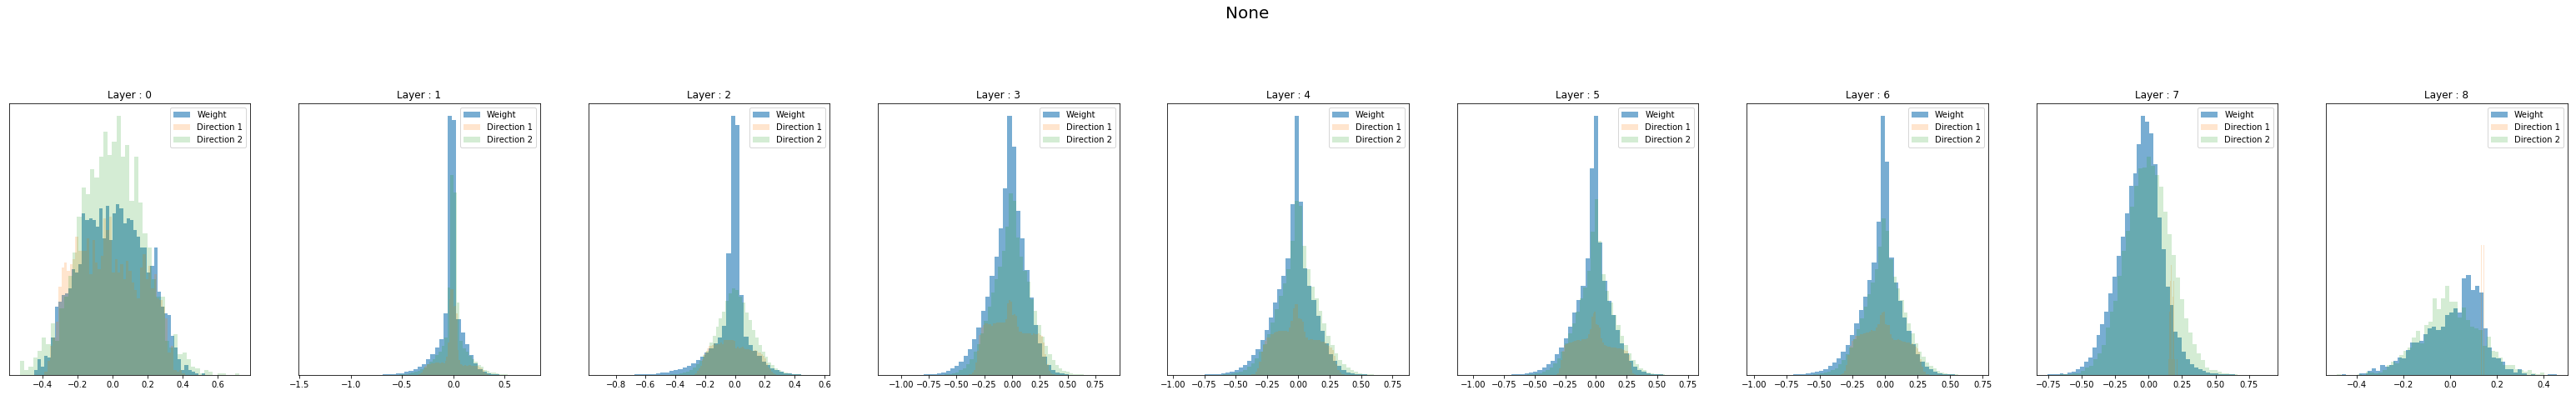

In [26]:
viz_histogram_weights(copy_of_the_weights,random_direction1,random_direction2)

In [27]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(random_direction1, random_direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 9.446022727272727	Loss: 2.374
count: 2	Coord: [-0.8 -1. ]		Acc: 9.943181818181818	Loss: 2.612
count: 4	Coord: [-0.6 -1. ]		Acc: 11.150568181818182	Loss: 3.573
count: 6	Coord: [-0.4 -1. ]		Acc: 12.997159090909092	Loss: 8.337
count: 8	Coord: [-0.2 -1. ]		Acc: 12.713068181818182	Loss: 20.355
count: 10	Coord: [ 0. -1.]		Acc: 17.116477272727273	Loss: 34.46
count: 12	Coord: [ 0.2 -1. ]		Acc: 14.772727272727273	Loss: 70.313
count: 14	Coord: [ 0.4 -1. ]		Acc: 11.71875	Loss: 111.339
count: 16	Coord: [ 0.6 -1. ]		Acc: 10.369318181818182	Loss: 121.975
count: 18	Coord: [ 0.8 -1. ]		Acc: 10.795454545454545	Loss: 109.322
count: 20	Coord: [ 1. -1.]		Acc: 10.227272727272727	Loss: 91.134
count: 22	Coord: [-0.9 -0.9]		Acc: 10.440340909090908	Loss: 2.375
count: 24	Coord: [-0.7 -0.9]		Acc: 10.298295454545455	Loss: 2.688
count: 26	Coord: [-0.5 -0.9]		Acc: 12.784090909090908	Loss: 4.187
count: 28	Coord: [-0.3 -0.9]		Acc: 14.559659090909092	Loss: 10.816
count: 30	Coord: [-0.1 

count: 250	Coord: [0.9 0.1]		Acc: 8.664772727272727	Loss: 49.593
count: 252	Coord: [-1.   0.2]		Acc: 11.505681818181818	Loss: 2.301
count: 254	Coord: [-0.8  0.2]		Acc: 16.974431818181817	Loss: 2.277
count: 256	Coord: [-0.6  0.2]		Acc: 28.125	Loss: 2.117
count: 258	Coord: [-0.4  0.2]		Acc: 61.57670454545455	Loss: 1.243
count: 260	Coord: [-0.2  0.2]		Acc: 88.35227272727273	Loss: 0.358
count: 262	Coord: [0.  0.2]		Acc: 95.38352272727273	Loss: 0.187
count: 264	Coord: [0.2 0.2]		Acc: 83.23863636363636	Loss: 1.836
count: 266	Coord: [0.4 0.2]		Acc: 44.81534090909091	Loss: 14.526
count: 268	Coord: [0.6 0.2]		Acc: 17.68465909090909	Loss: 40.254
count: 270	Coord: [0.8 0.2]		Acc: 10.440340909090908	Loss: 50.178
count: 272	Coord: [1.  0.2]		Acc: 8.877840909090908	Loss: 53.522
count: 274	Coord: [-0.9  0.3]		Acc: 13.494318181818182	Loss: 2.293
count: 276	Coord: [-0.7  0.3]		Acc: 21.59090909090909	Loss: 2.227
count: 278	Coord: [-0.5  0.3]		Acc: 40.98011363636363	Loss: 1.84
count: 280	Coord: [-0.3  0.

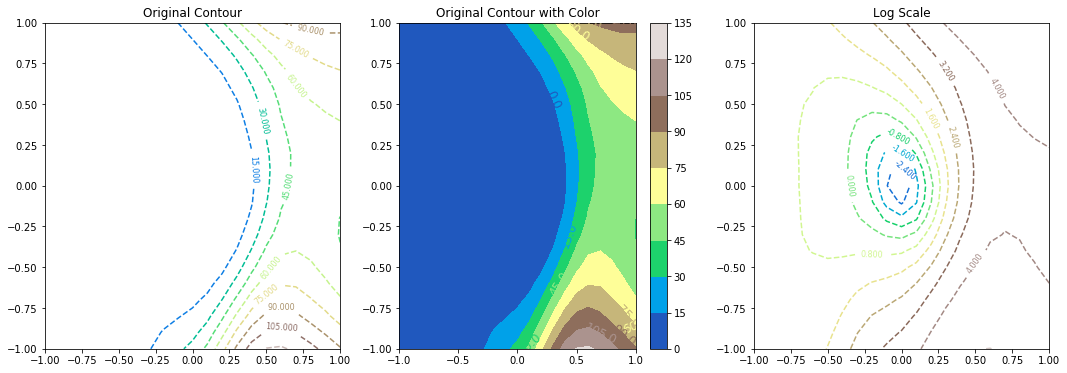

In [28]:
create_viz(loss_list,acc_list)

# ==== 3. Weight - Orthogonal - whole norm ====

In [29]:
# np.save('c_loss_list_2.npy', np.asarray(loss_list))
# np.save('c_acc_list_2.npy', np.asarray(acc_list))
random_direction1 = []
random_direction2 = []

for w in copy_of_the_weights:
    
    if w.dim() == 1: 
        random_direction1.append(torch.zeros_like(w))
        random_direction2.append(torch.zeros_like(w))
        
    else:
        random_vector = w.clone().cpu().numpy()
        
        random_vector1 = random_vector - random_vector.mean((2,3),keepdims=True)
        random_vector2 = random_vector - random_vector.mean((0,1),keepdims=True)
        random_vector2 = np.transpose(random_vector2,(2,3,0,1))
        
        sigma1 = tf.matmul(tf.transpose(random_vector1,(0,1,3,2)),random_vector1) / random_vector1.shape[3]
        sigma2 = tf.matmul(tf.transpose(random_vector2,(0,1,3,2)),random_vector2) / random_vector2.shape[3]

        s1,u1,v1 = tf.linalg.svd(sigma1,False)
        s2,u2,v2 = tf.linalg.svd(sigma2,False)
        
        tmp1 =  tf.matmul(u1,1/(tf.sqrt(tf.linalg.diag(s1))+1e-5))
        tmp1 = tmp1 @ tf.transpose(u1,(0,1,3,2))
        
        tmp2 =  tf.matmul(u2,1/(tf.sqrt(tf.linalg.diag(s2))+1e-5))
        tmp2 = tmp2 @ tf.transpose(u2,(0,1,3,2))
        
        random_vector1 = random_vector1 @ tf.transpose(tmp1,(0,1,3,2))
        random_vector2 = random_vector2 @ tf.transpose(tmp2,(0,1,3,2))
        random_vector2 = tf.transpose(random_vector2,(2,3,0,1))
        
        random_vector1 = torch.from_numpy(random_vector1.eval()).cuda()
        random_vector2 = torch.from_numpy(random_vector2.eval()).cuda()

        w_norm  = w.view((w.shape[0],-1))  .norm(dim=(1),keepdim=True)[:,:,None,None]
        d_norm1 = random_vector1.view((random_vector1.shape[0],-1)).norm(dim=(1),keepdim=True)[:,:,None,None]
        d_norm2 = random_vector2.view((random_vector2.shape[0],-1)).norm(dim=(1),keepdim=True)[:,:,None,None]

        random_vector1 = random_vector1 * (w_norm/(d_norm1.cuda()+1e-10))
        random_vector2 = random_vector2 * (w_norm/(d_norm2.cuda()+1e-10))  
        
        print(random_vector1.shape)
        print(random_vector2.shape)

        random_direction1.append(random_vector1)
        random_direction2.append(random_vector2)

torch.Size([96, 3, 3, 3])
torch.Size([96, 3, 3, 3])
torch.Size([96, 96, 3, 3])
torch.Size([96, 96, 3, 3])
torch.Size([96, 96, 3, 3])
torch.Size([96, 96, 3, 3])
torch.Size([192, 96, 3, 3])
torch.Size([192, 96, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([10, 192, 1, 1])
torch.Size([10, 192, 1, 1])


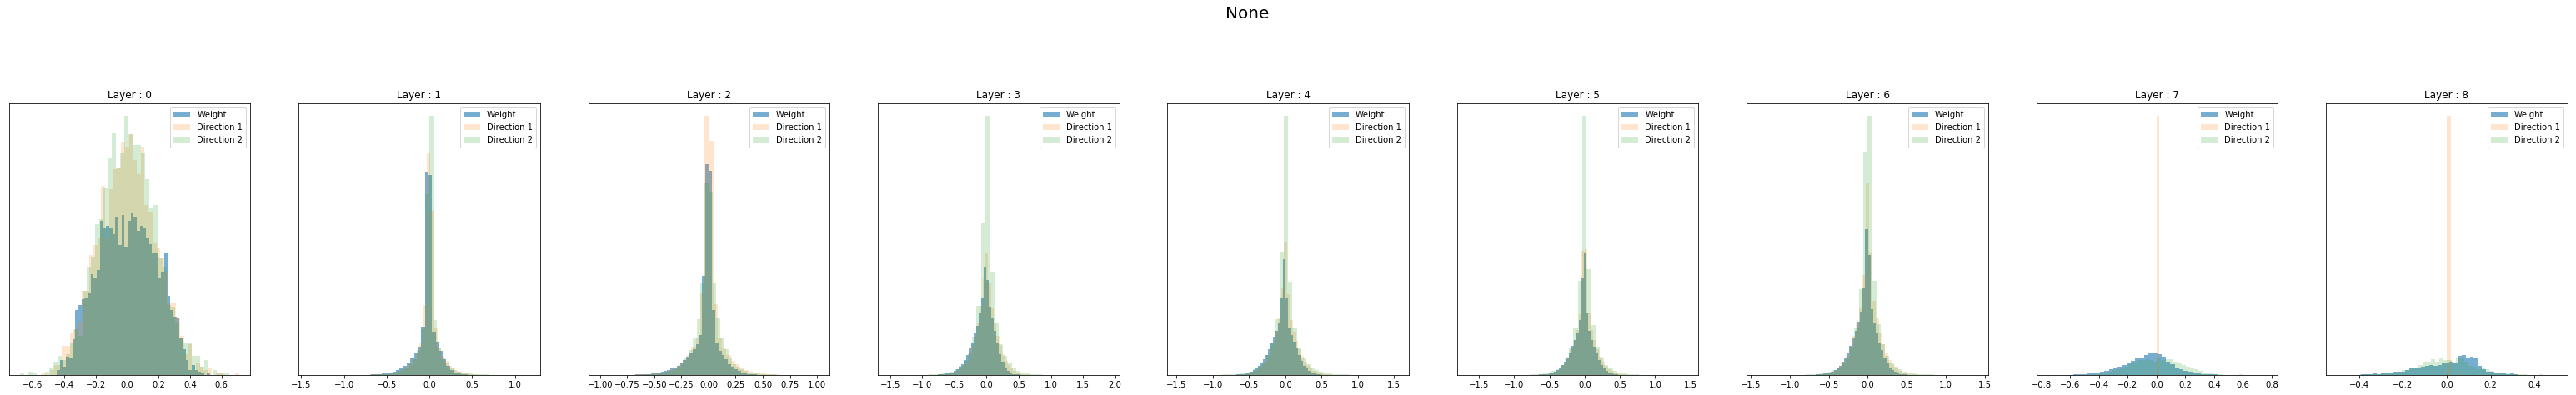

In [30]:
viz_histogram_weights(copy_of_the_weights,random_direction1,random_direction2)

In [31]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(random_direction1, random_direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 11.363636363636363	Loss: 62.495
count: 2	Coord: [-0.8 -1. ]		Acc: 12.855113636363637	Loss: 58.542
count: 4	Coord: [-0.6 -1. ]		Acc: 11.505681818181818	Loss: 53.224
count: 6	Coord: [-0.4 -1. ]		Acc: 14.346590909090908	Loss: 53.157
count: 8	Coord: [-0.2 -1. ]		Acc: 13.707386363636363	Loss: 67.371
count: 10	Coord: [ 0. -1.]		Acc: 12.357954545454545	Loss: 90.175
count: 12	Coord: [ 0.2 -1. ]		Acc: 12.215909090909092	Loss: 102.852
count: 14	Coord: [ 0.4 -1. ]		Acc: 12.002840909090908	Loss: 103.349
count: 16	Coord: [ 0.6 -1. ]		Acc: 13.210227272727273	Loss: 96.787
count: 18	Coord: [ 0.8 -1. ]		Acc: 13.28125	Loss: 91.127
count: 20	Coord: [ 1. -1.]		Acc: 13.707386363636363	Loss: 86.725
count: 22	Coord: [-0.9 -0.9]		Acc: 13.565340909090908	Loss: 48.74
count: 24	Coord: [-0.7 -0.9]		Acc: 12.215909090909092	Loss: 43.879
count: 26	Coord: [-0.5 -0.9]		Acc: 13.068181818181818	Loss: 42.209
count: 28	Coord: [-0.3 -0.9]		Acc: 15.767045454545455	Loss: 45.815
count: 30	Coord

count: 248	Coord: [0.7 0.1]		Acc: 20.880681818181817	Loss: 12.117
count: 250	Coord: [0.9 0.1]		Acc: 17.47159090909091	Loss: 12.51
count: 252	Coord: [-1.   0.2]		Acc: 10.582386363636363	Loss: 10.852
count: 254	Coord: [-0.8  0.2]		Acc: 12.357954545454545	Loss: 11.306
count: 256	Coord: [-0.6  0.2]		Acc: 14.275568181818182	Loss: 12.422
count: 258	Coord: [-0.4  0.2]		Acc: 33.02556818181818	Loss: 7.853
count: 260	Coord: [-0.2  0.2]		Acc: 75.63920454545455	Loss: 1.622
count: 262	Coord: [0.  0.2]		Acc: 87.57102272727273	Loss: 0.634
count: 264	Coord: [0.2 0.2]		Acc: 64.77272727272727	Loss: 2.959
count: 266	Coord: [0.4 0.2]		Acc: 35.79545454545455	Loss: 7.731
count: 268	Coord: [0.6 0.2]		Acc: 23.72159090909091	Loss: 10.828
count: 270	Coord: [0.8 0.2]		Acc: 19.460227272727273	Loss: 11.591
count: 272	Coord: [1.  0.2]		Acc: 15.056818181818182	Loss: 11.843
count: 274	Coord: [-0.9  0.3]		Acc: 11.008522727272727	Loss: 11.618
count: 276	Coord: [-0.7  0.3]		Acc: 12.784090909090908	Loss: 12.459
count: 27

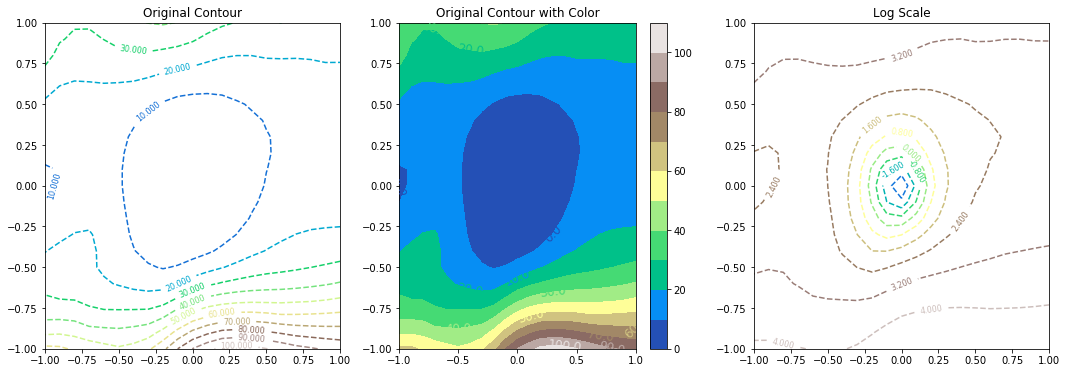

In [ ]:
create_viz(loss_list,acc_list)

# ==== 4. Weight - PCA - whole norm ====

In [ ]:
np.save('c_loss_list_3.npy', np.asarray(loss_list))
np.save('c_acc_list_3.npy', np.asarray(acc_list))
random_direction1 = []
random_direction2 = []

for w in copy_of_the_weights:
    
    if w.dim() == 1: 
        random_direction1.append(torch.zeros_like(w))
        random_direction2.append(torch.zeros_like(w))
        
    else:
        random_vector = w.clone().cpu().numpy()
        
        random_vector1 = random_vector - random_vector.mean((2,3),keepdims=True)
        random_vector2 = random_vector - random_vector.mean((0,1),keepdims=True)
        random_vector2 = np.transpose(random_vector2,(2,3,0,1))
        
        s1,u1,v1 = tf.linalg.svd(random_vector1,False)
        s2,u2,v2 = tf.linalg.svd(random_vector2,False)
        
        random_vector1 = u1 @ tf.linalg.diag(s1)[:,:,:,:1] @ tf.transpose(v1,(0,1,3,2))[:,:,:1,:]
        random_vector2 = u2 @ tf.linalg.diag(s2)[:,:,:,:1] @ tf.transpose(v2,(0,1,3,2))[:,:,:1,:]
        random_vector2 = tf.transpose(random_vector2,(2,3,0,1))
        
        random_vector1 = torch.from_numpy(random_vector1.eval()).cuda()
        random_vector2 = torch.from_numpy(random_vector2.eval()).cuda()

        w_norm  = w.view((w.shape[0],-1))  .norm(dim=(1),keepdim=True)[:,:,None,None]
        d_norm1 = random_vector1.view((random_vector1.shape[0],-1)).norm(dim=(1),keepdim=True)[:,:,None,None]
        d_norm2 = random_vector2.view((random_vector2.shape[0],-1)).norm(dim=(1),keepdim=True)[:,:,None,None]

        random_vector1 = random_vector1 * (w_norm/(d_norm1.cuda()+1e-10))
        random_vector2 = random_vector2 * (w_norm/(d_norm2.cuda()+1e-10))  
        
        print(random_vector1.shape)
        print(random_vector2.shape)

        random_direction1.append(random_vector1)
        random_direction2.append(random_vector2)

torch.Size([96, 3, 3, 3])
torch.Size([96, 3, 3, 3])
torch.Size([96, 96, 3, 3])
torch.Size([96, 96, 3, 3])
torch.Size([96, 96, 3, 3])
torch.Size([96, 96, 3, 3])
torch.Size([192, 96, 3, 3])
torch.Size([192, 96, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 1, 1])
torch.Size([192, 192, 1, 1])
torch.Size([10, 192, 1, 1])
torch.Size([10, 192, 1, 1])


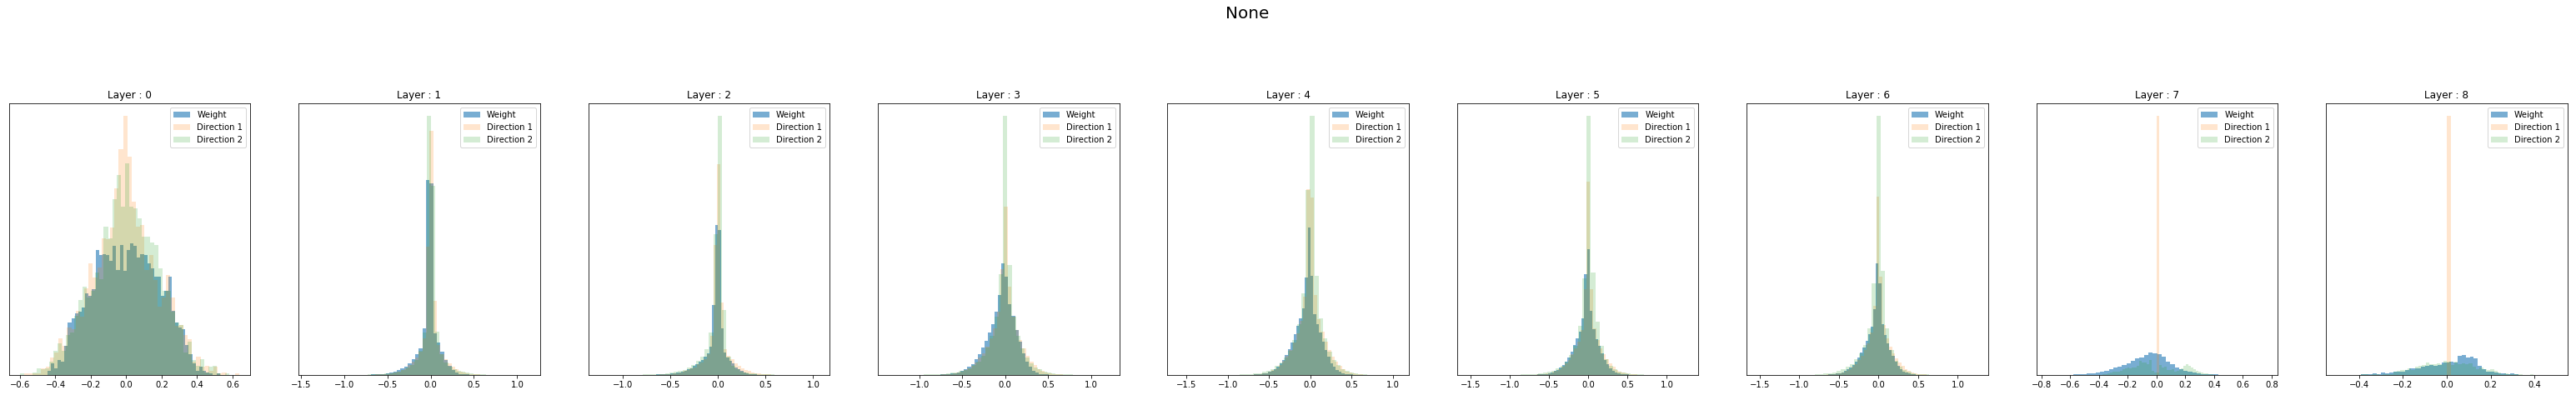

In [ ]:
viz_histogram_weights(copy_of_the_weights,random_direction1,random_direction2)

In [ ]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(random_direction1, random_direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 10.15625	Loss: 9.523
count: 2	Coord: [-0.8 -1. ]		Acc: 10.014204545454545	Loss: 9.772
count: 4	Coord: [-0.6 -1. ]		Acc: 9.375	Loss: 10.07
count: 6	Coord: [-0.4 -1. ]		Acc: 10.15625	Loss: 9.374
count: 8	Coord: [-0.2 -1. ]		Acc: 10.15625	Loss: 8.89
count: 10	Coord: [ 0. -1.]		Acc: 10.227272727272727	Loss: 9.197
count: 12	Coord: [ 0.2 -1. ]		Acc: 10.014204545454545	Loss: 9.895
count: 14	Coord: [ 0.4 -1. ]		Acc: 9.801136363636363	Loss: 11.018
count: 16	Coord: [ 0.6 -1. ]		Acc: 9.446022727272727	Loss: 16.74
count: 18	Coord: [ 0.8 -1. ]		Acc: 9.588068181818182	Loss: 21.145
count: 20	Coord: [ 1. -1.]		Acc: 10.014204545454545	Loss: 21.418


In [ ]:
create_viz(loss_list,acc_list)

In [ ]:
np.save('c_loss_list_4.npy', np.asarray(loss_list))
np.save('c_acc_list_4.npy', np.asarray(acc_list))